In [6]:
import numpy as np  # linear algebra
import cv2
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import tensorflow as tf
from tensorflow import keras
from keras import models
from tensorflow.keras.utils import to_categorical, plot_model
from moviepy.editor import *
from PIL import Image
from audio_spectrogram import stft
from keras import layers


In [7]:
def identity_encoder():
    """A model for receiving the image as a numpy array."""
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(256, 256, 3), name="image_input"),
        tf.keras.layers.Conv2D(3, 7, 1, activation='relu'),
        tf.keras.layers.Conv2D(32, 5, (1, 2), activation='relu'),
        tf.keras.layers.Conv2D(64, 5, 2, activation='relu'),
        tf.keras.layers.Conv2D(128, 5, 2, activation='relu'),
        tf.keras.layers.Conv2D(256, 3, 2, activation='relu'),
        tf.keras.layers.Conv2D(512, 3, 2, activation='relu'),
        tf.keras.layers.Conv2D(512, 3, 1, activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='sigmoid')
    ], name="image")
    model.summary()
    return model

In [8]:
def audio_encoder():
    """A model for receiving the audio as a numpy array."""
    loudness = 80  # Probably the decibel of the sound. Not sure how it's like that. tbf, I actually have no clue if the variable name is c
    # correct for this value.
    step_size = 34  # Presumably the time each frame occupies. So a frame can last like 1/30th of a second if the video is in 30FPS.

    shape_of_audio_np = (6, 513, 1)

    num_labels = 64
    # Instantiate the `tf.keras.layers.Normalization` layer.
    norm_layer = layers.Normalization()
    # Fit the state of the layer to the spectrograms
    # with `Normalization.adapt`.
    # norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))  May have to remove this.

    model = models.Sequential([
        layers.Input(shape=shape_of_audio_np, name="audio_input"),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ], name="audio")
    model.summary()
    return model

In [9]:
identity_model = identity_encoder()
audio_model = audio_encoder()

Model: "image"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 3)       444       
                                                                 
 conv2d_1 (Conv2D)           (None, 246, 123, 32)      2432      
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 60, 64)       51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 59, 28, 128)       204928    
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 13, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 6, 512)        1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 4, 512)        235980

2023-01-26 14:58:48.009317: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-26 14:58:48.009340: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x13-fedora): /proc/driver/nvidia/version does not exist
2023-01-26 14:58:48.009611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 audio_input (InputLayer)       [(None, 6, 513, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 3)  444         ['image_input[0][0]']            
                                                                                                  
 resizing (Resizing)            (None, 32, 32, 1)    0           ['audio_input[0][0]'

Non-trainable params: 393,627
__________________________________________________________________________________________________


2023-01-26 14:58:48.740549: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648 exceeds 10% of free system memory.
2023-01-26 14:58:48.748413: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648 exceeds 10% of free system memory.
2023-01-26 14:58:48.757587: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648 exceeds 10% of free system memory.


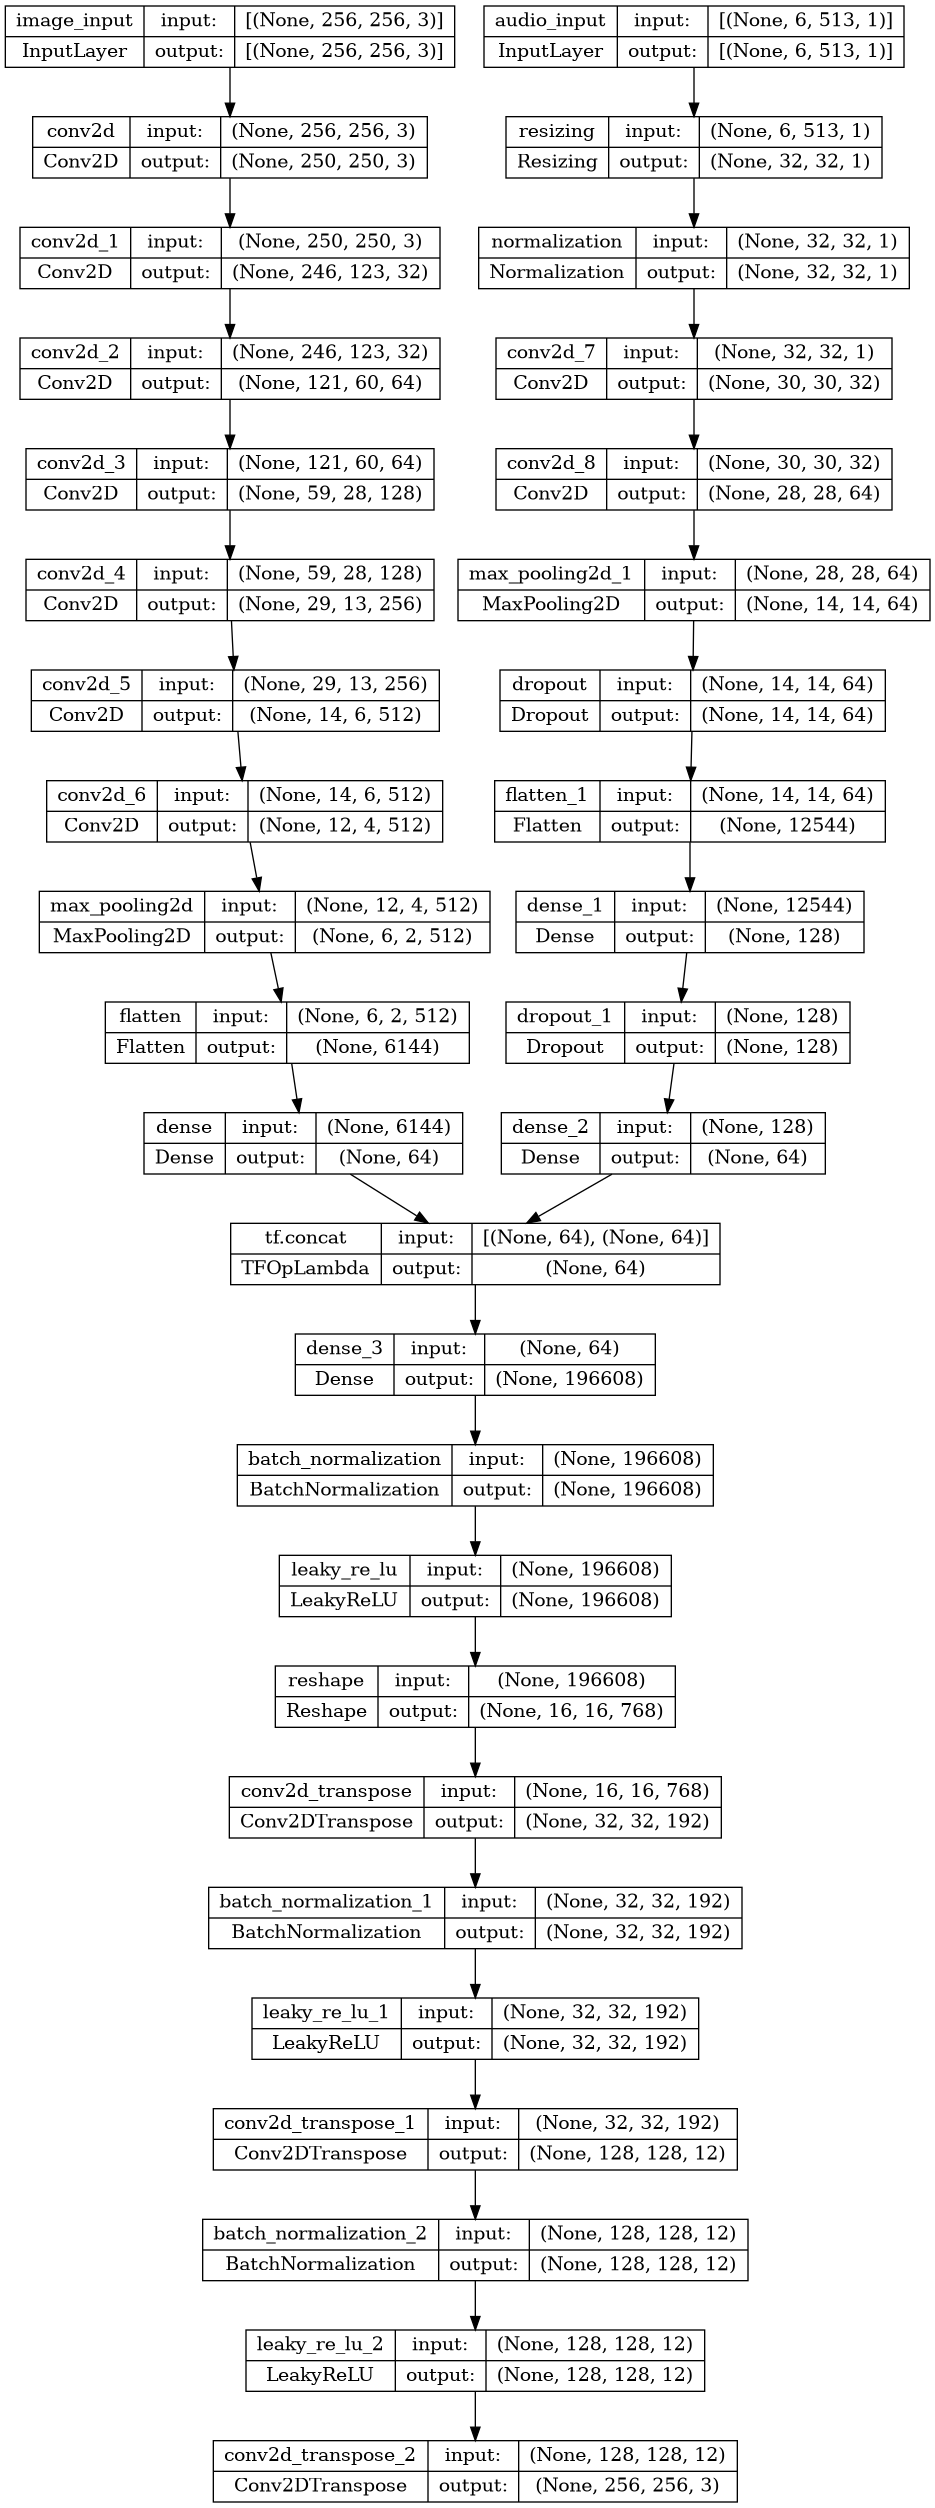

In [10]:
# The combined model

# x = layers.Concatenate([identity_model.layers[-1].output, audio_model.layers[-1].output])
x = tf.concat([identity_model.layers[-1].output, audio_model.layers[-1].output], 0)

combined_output = layers.Dense(16*16*768, use_bias=False)(x)
combined_output = layers.BatchNormalization()(combined_output)
combined_output = layers.LeakyReLU()(combined_output)

combined_output = layers.Reshape((16, 16, 768))(combined_output)
# assert tf.shape(combined_output) == (None, 16, 16, 768)  # Note: None is the batch size

combined_output = layers.Conv2DTranspose(192, (5, 5), strides=(2, 2), padding='same', use_bias=False)(combined_output)
# assert combined_output.output_shape == (None, 32, 32, 192)
# assert tf.shape(combined_output) == (None, 32, 32, 192)
combined_output = layers.BatchNormalization()(combined_output)
combined_output = layers.LeakyReLU()(combined_output)

combined_output = layers.Conv2DTranspose(12, (5, 5), strides=(4, 4), padding='same', use_bias=False)(combined_output)
# assert tf.shape(combined_output) == (None, 128, 128, 12)
combined_output = layers.BatchNormalization()(combined_output)
combined_output = layers.LeakyReLU()(combined_output)

combined_output = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(combined_output)
# assert tf.shape(combined_output) == (None, 256, 256, 3)


combined_model = keras.Model(inputs=[identity_model.layers[0].input, audio_model.layers[0].input],
                             outputs=[combined_output], name="combined_model")
combined_model.summary()

# Definitely liable to change. Generator is a combined model.
combined_model.compile(
    optimizer='adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

plot_model(combined_model, "image_and_text_classifier.png", show_shapes=True)

In [15]:
def testing():
    print("testing")
    img = Image.open("/home/hnguyen/PycharmProjects/deepfake-lip-sync/dataset/train/fake/FAKE_aahsnkchkz.mp4_125.png")
    seed_1 = np.asarray(img)
    filepath = f"/home/hnguyen/PycharmProjects/deepfake-lip-sync/utils/audio/vmigrsncac_audio_132.wav"
    samplerate, samples = wav.read(filepath)

    seed_2 = stft(samples, 2 ** 10)
    seed_2 = np.reshape(seed_2, newshape=(6, 513, 1))
    combined_inputs = {"image_input": np.expand_dims(seed_1, axis=0),
                       "audio_input": np.expand_dims(seed_2, axis=0)}
    print(combined_inputs["image_input"].shape)
    print(combined_inputs["audio_input"].shape)
    generated_img = combined_model(combined_inputs, training=False)
    # print(generated_img.shape)
    print(generated_img)
    print("done.")
    plt.imshow(generated_img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


testing
(1, 256, 256, 3)
(1, 6, 513, 1)
tf.Tensor(
[[[[ 9.71828849e-05 -1.07603293e-04 -1.28910135e-04]
   [ 1.81246243e-04 -3.84194427e-05  2.34502077e-04]
   [-1.89980114e-04  1.41305864e-04 -1.17508651e-04]
   ...
   [ 5.55956212e-04  1.12549023e-04  4.85544151e-04]
   [-1.72947708e-04  4.93440661e-04 -4.55106696e-04]
   [-3.07916955e-04  7.69903545e-06  2.47951306e-04]]

  [[ 4.45327634e-04 -2.50095909e-05 -2.81430403e-04]
   [-8.91381060e-05 -4.07289801e-04 -1.28551081e-04]
   [ 1.28391184e-04 -1.63708261e-04  1.27528183e-04]
   ...
   [ 2.62061891e-04 -3.62868712e-04  1.56310285e-04]
   [ 3.03267327e-04 -6.14859629e-04 -4.14224254e-04]
   [ 1.45122583e-04 -4.36324248e-04  3.89016350e-05]]

  [[-2.51581834e-04 -5.25700707e-05 -2.31806334e-04]
   [-1.76050235e-05  3.53186857e-04  2.28169374e-04]
   [-3.45936540e-04 -1.45610364e-04 -1.72403510e-04]
   ...
   [-4.11937013e-04  1.80532792e-04  7.54623325e-04]
   [-5.82888490e-04 -1.54269597e-04  4.01565339e-04]
   [-1.67142804e-04 -6.

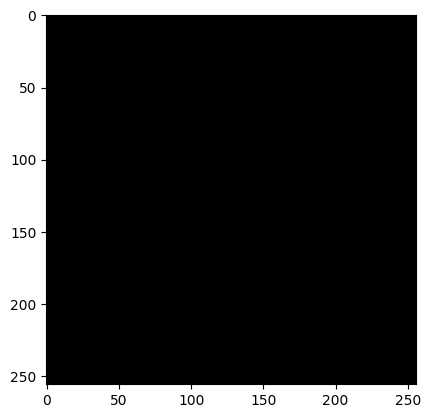

In [16]:
testing()